In [2]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import curvedsky as cs
import os
sys.path.append('..')

In [3]:
%load_ext autoreload
%autoreload 2
from solat_cb.data import *
from solat_cb.simulation import CMB, BandpassInt, Foreground, Mask, Noise, LATsky, SATsky

In [4]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

In [5]:
nside = 1024
lmax = 3*nside - 1
alpha = [0.0,0.0,0.0,0.0,0.0,0.0]
Tcmb = 2.726e6

In [6]:
lat_aniso = LATsky(lib,nside,'aniso',1,1,alpha,Acb=1e-4,verbose=True,nsplits=1)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
Noise : INFO - Noise Model: White noise v3.0.0


In [7]:
EB, neb = lat_aniso.HILC_obsEB(0)

In [8]:
lcl = (lat_aniso.cmb.get_lensed_spectra(dl=False,dtype='a')/Tcmb**2).T

In [36]:
Ealm = cs.utils.lm_healpy2healpix(EB[0]/Tcmb,lmax)
Balm = cs.utils.lm_healpy2healpix(EB[1]/Tcmb,lmax)

In [37]:
almax  = 2048 
rlmin = 50
rlmax = 2048 

In [38]:
L = np.linspace(0,almax,almax+1)

In [39]:

nl  = np.zeros((4,almax+1))
nl[1,:] = neb[0][:almax+1]/Tcmb**2
nl[2,:] = neb[1][:almax+1]/Tcmb**2
ocl = lcl[:,:almax+1] + nl

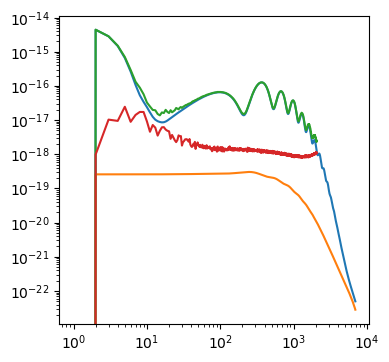

In [40]:
plt.figure(figsize=(4,4))
plt.loglog(lcl[1,:],label='EE')
plt.loglog(lcl[2,:],label='BB')
plt.loglog(ocl[1,:],label='EE + noise')
plt.loglog(ocl[2,:],label='BB + noise')

In [41]:
Fl = np.zeros((3,almax+1,almax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [42]:
Al = np.zeros((2,almax+1))
Al[0,:] = cs.norm_quad.qeb('rot',almax,rlmin,rlmax,lcl[1,:rlmax+1],ocl[1,:rlmax+1],ocl[2,:rlmax+1])[0]
Al[1,:] = cs.norm_quad.qtb('rot',almax,rlmin,rlmax,lcl[3,:rlmax+1],ocl[0,:rlmax+1],ocl[2,:rlmax+1])[0]

In [43]:
Ealm = Ealm[:almax+1,:almax+1]
Balm = Balm[:almax+1,:almax+1]

In [44]:
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

In [45]:
alm = cs.rec_rot.qeb(lmax,rlmin,rlmax,lcl[1,:rlmax+1],Ealm[:rlmax+1,:rlmax+1],Balm[:rlmax+1,:rlmax+1])

 compute polarization rotation


In [46]:
norm_aalm = alm[:almax+1,:almax+1] * Al[0][:,None]

In [47]:
input_aalm = cs.utils.hp_map2alm(lat_aniso.cmb.nside,lmax,lmax,lat_aniso.cmb.alpha_map(0))

In [48]:
cl_recon = cs.utils.alm2cl(almax,norm_aalm)
cl_input = cs.utils.alm2cl(almax,input_aalm[:almax+1,:almax+1])
cl_r_i = cs.utils.alm2cl(almax,norm_aalm,input_aalm[:almax+1,:almax+1])

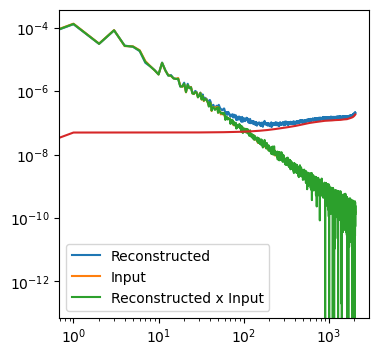

In [49]:
plt.figure(figsize=(4,4))
plt.loglog(cl_recon,label='Reconstructed')
plt.loglog(cl_input,label='Input')
plt.loglog(cl_r_i,label='Reconstructed x Input')
plt.loglog(Al[0])
#plt.ylim(1e-13,1e-2)
plt.legend()